In [9]:
import cv2
import numpy as np
import torch
import torchvision.models as models
import torch.nn as nn
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import os, time, matplotlib.pyplot as plt

In [21]:
VIDEO_PATH = "deadlift2.mp4"
FRAME_DIR = "frames"
NORMAL_DIR = os.path.join(FRAME_DIR, "normal")
BLUR_DIR = os.path.join(FRAME_DIR, "blur")
PATCH_SIZE = 64
VISUAL_DIR = "match_visuals"
N_COMPONENTS = 3
SIM_THRESH = 0.8
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
EXTRACT_EVERY = 10  # extract every 10th frame
os.makedirs(VISUAL_DIR, exist_ok=True)

In [15]:
def extract_frames(video_path, out_dir, every_n=10):
    os.makedirs(out_dir, exist_ok=True)
    cap = cv2.VideoCapture(video_path)
    total = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_id = 0
    saved = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_id % every_n == 0:
            out_path = os.path.join(out_dir, f"frame_{saved:04d}.jpg")
            cv2.imwrite(out_path, frame)
            saved += 1
        frame_id += 1
    cap.release()
    print(f"✅ Extracted {saved} frames from video → {out_dir}")

def generate_blurred_versions(src_dir, dst_dir, ksize=15):
    os.makedirs(dst_dir, exist_ok=True)
    for f in sorted(os.listdir(src_dir)):
        img = cv2.imread(os.path.join(src_dir, f))
        if img is None:
            continue
        kernel = np.zeros((ksize, ksize))
        kernel[int((ksize - 1) / 2), :] = np.ones(ksize)
        kernel = kernel / ksize
        blurred = cv2.filter2D(img, -1, kernel)
        cv2.imwrite(os.path.join(dst_dir, f), blurred)
    print(f"✅ Generated blurred frames → {dst_dir}")

In [23]:
def visualize_matches(img1, img2, kp1, kp2, desc1, desc2, method_name, idx, top_n=30):
    if desc1 is None or desc2 is None:
        return
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True) if method_name == "AKAZE" else cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    matches = bf.match(desc1, desc2)
    matches = sorted(matches, key=lambda x: x.distance)[:top_n]
    matched_img = cv2.drawMatches(img1, kp1, img2, kp2, matches, None,
                                  flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    out_path = os.path.join(VISUAL_DIR, f"matches_{method_name.lower()}_{idx:02d}.jpg")
    cv2.imwrite(out_path, matched_img)
    print(f"💾 Saved {method_name} match visualization → {out_path}")


In [5]:
def extract_akaze(gray):
    """Extract AKAZE keypoints + descriptors."""
    akaze = cv2.AKAZE_create()
    kps, desc = akaze.detectAndCompute(gray, None)
    return kps, desc

class DeepHOGDescriptor:
    """CNN (mid-layer) + PCA + HOG feature descriptor."""
    def __init__(self, n_components=3, patch_size=64):
        self.model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1).features[:16].to(DEVICE).eval()
        self.pca = PCA(n_components=n_components)
        self.patch_size = patch_size

    def fit_pca(self, gray_list):
        feats = []
        for g in gray_list:
            g_t = torch.tensor(g / 255.0).float().unsqueeze(0).unsqueeze(0).repeat(1,3,1,1).to(DEVICE)
            fmap = self.model(g_t).detach().cpu().numpy()[0]
            fmap_flat = fmap.reshape(fmap.shape[0], -1).T
            feats.append(fmap_flat.mean(axis=0))
        X = np.vstack(feats)
        self.pca.fit(X)
        print("✅ PCA trained")

    def describe_patch(self, gray_patch):
        g_t = torch.tensor(gray_patch / 255.0).float().unsqueeze(0).unsqueeze(0).repeat(1,3,1,1).to(DEVICE)
        fmap = self.model(g_t).detach().cpu().numpy()[0]  # (C, H, W)
        fmap_flat = fmap.reshape(fmap.shape[0], -1).T
        fmap_pca = self.pca.transform(fmap_flat)
        fmap_pca = fmap_pca.T  # (N_comp, HW)
        # Compute HOG for each PCA channel
        hogs = []
        for i in range(fmap_pca.shape[0]):
            ch = fmap_pca[i].reshape(int(np.sqrt(fmap_pca.shape[1])), -1)
            h = cv2.HOGDescriptor(_winSize=(ch.shape[1]//8*8, ch.shape[0]//8*8),
                                  _blockSize=(16,16),
                                  _blockStride=(8,8),
                                  _cellSize=(8,8),
                                  _nbins=9)
            hvec = h.compute((ch*255).astype(np.uint8))
            hogs.append(hvec.flatten())
        desc = np.concatenate(hogs)
        desc = desc / (np.linalg.norm(desc) + 1e-8)
        return desc

In [25]:
def crop_patches(gray, kps, patch_size):
    patches = []
    h, w = gray.shape
    half = patch_size // 2
    for kp in kps:
        x, y = int(kp.pt[0]), int(kp.pt[1])
        if x-half < 0 or y-half < 0 or x+half >= w or y+half >= h:
            continue
        patch = gray[y-half:y+half, x-half:x+half]
        patches.append(patch)
    return patches

def average_similarity(desc1, desc2):
    if desc1 is None or desc2 is None or len(desc1)==0 or len(desc2)==0:
        return 0
    sim = cosine_similarity(desc1, desc2)
    return np.mean(np.max(sim, axis=1))

# ======================
# MAIN EVALUATION
# ======================
def evaluate_descriptor(method_name, extractor_fn, visualize=False):
    sims, fps_list = [], []
    files = sorted(os.listdir(NORMAL_DIR))[:10]
    for i, fname in enumerate(files):
        p1 = os.path.join(NORMAL_DIR, fname)
        p2 = os.path.join(BLUR_DIR, fname)
        if not os.path.exists(p2): continue
        g1 = cv2.imread(p1, cv2.IMREAD_GRAYSCALE)
        g2 = cv2.imread(p2, cv2.IMREAD_GRAYSCALE)
        if g1 is None or g2 is None: continue

        start = time.time()
        kp1, desc1 = extractor_fn(g1)
        kp2, desc2 = extractor_fn(g2)
        sim = average_similarity(desc1, desc2)
        sims.append(sim)
        fps_list.append(1/(time.time()-start))

        if visualize:
            visualize_matches(g1, g2, kp1, kp2, desc1, desc2, method_name, i)
    return {"method": method_name,
            "mean_sim": np.mean(sims),
            "std_sim": np.std(sims),
            "avg_fps": np.mean(fps_list)}



🔹 Evaluating AKAZE...
💾 Saved AKAZE match visualization → match_visuals\matches_akaze_01.jpg
💾 Saved AKAZE match visualization → match_visuals\matches_akaze_02.jpg
💾 Saved AKAZE match visualization → match_visuals\matches_akaze_03.jpg
💾 Saved AKAZE match visualization → match_visuals\matches_akaze_04.jpg
💾 Saved AKAZE match visualization → match_visuals\matches_akaze_05.jpg
💾 Saved AKAZE match visualization → match_visuals\matches_akaze_06.jpg
💾 Saved AKAZE match visualization → match_visuals\matches_akaze_07.jpg
💾 Saved AKAZE match visualization → match_visuals\matches_akaze_08.jpg
💾 Saved AKAZE match visualization → match_visuals\matches_akaze_09.jpg

🔹 Preparing PCA-Deep-SIFT-HOG...
✅ PCA trained

🔹 Evaluating PCA-Deep-SIFT-HOG...
💾 Saved PCA-Deep-SIFT-HOG match visualization → match_visuals\matches_pca-deep-sift-hog_01.jpg
💾 Saved PCA-Deep-SIFT-HOG match visualization → match_visuals\matches_pca-deep-sift-hog_02.jpg
💾 Saved PCA-Deep-SIFT-HOG match visualization → match_visuals\mat

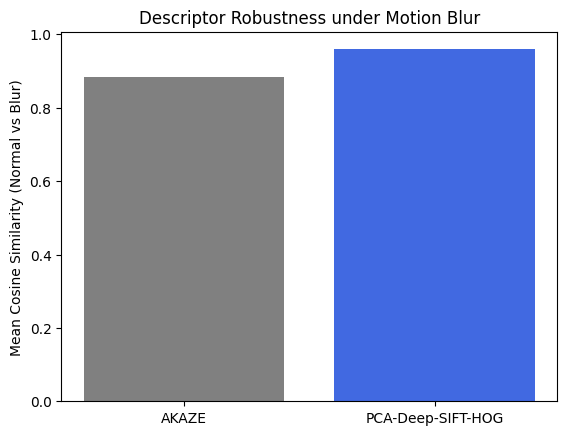

In [29]:
if __name__ == "__main__":
    # Step 1. Prepare frames
    if not os.path.exists(NORMAL_DIR) or len(os.listdir(NORMAL_DIR)) == 0:
        extract_frames(VIDEO_PATH, NORMAL_DIR, every_n=EXTRACT_EVERY)
    if not os.path.exists(BLUR_DIR) or len(os.listdir(BLUR_DIR)) == 0:
        generate_blurred_versions(NORMAL_DIR, BLUR_DIR)

    # Step 2. AKAZE baseline
    print("\n🔹 Evaluating AKAZE...")
    akaze_stats = evaluate_descriptor("AKAZE", extract_akaze, visualize=True)

    # Step 3. PCA-Deep-SIFT-HOG
    print("\n🔹 Preparing PCA-Deep-SIFT-HOG...")
    deep = DeepHOGDescriptor(n_components=N_COMPONENTS, patch_size=PATCH_SIZE)
    imgs = []
    for f in sorted(os.listdir(NORMAL_DIR))[:10]:
        g = cv2.imread(os.path.join(NORMAL_DIR, f), cv2.IMREAD_GRAYSCALE)
        if g is not None:
            imgs.append(g)
    if len(imgs) == 0:
        raise RuntimeError("No valid images found in frames/normal/ for PCA training.")

    patches = []
    for g in imgs:
        kp, _ = extract_akaze(g)
        if kp is None or len(kp) == 0:
            continue
        patches.extend(crop_patches(g, kp[:20], PATCH_SIZE))

    if len(patches) == 0:
        raise RuntimeError("No valid patches found for PCA training. Try increasing EXTRACT_EVERY or check frame folder.")

    deep.fit_pca(patches)

    def deep_extractor(g):
        kp, _ = extract_akaze(g)
        patches = crop_patches(g, kp[:15], PATCH_SIZE)
        descs = [deep.describe_patch(p) for p in patches]
        return kp, np.vstack(descs) if len(descs)>0 else None

    print("\n🔹 Evaluating PCA-Deep-SIFT-HOG...")
    deep_stats = evaluate_descriptor("PCA-Deep-SIFT-HOG", deep_extractor, visualize=True)

    # Step 4. Results
    print("\n=== RESULTS ===")
    for d in [akaze_stats, deep_stats]:
        print(f"{d['method']}: MeanSim={d['mean_sim']:.4f}, Std={d['std_sim']:.4f}, FPS={d['avg_fps']:.2f}")

    plt.bar(["AKAZE", "PCA-Deep-SIFT-HOG"],
            [akaze_stats["mean_sim"], deep_stats["mean_sim"]],
            color=["gray", "royalblue"])
    plt.ylabel("Mean Cosine Similarity (Normal vs Blur)")
    plt.title("Descriptor Robustness under Motion Blur")
    plt.show()